**This notebook is for:**
1. MODEL TEST.

In [4]:
# !pip install imblearn --upgrade
# !pip install statsmodels --upgrade
# !pip install scipy --upgrade
# !pip install scikit-learn --upgrade
# !pip install numpy --upgrade
# !pip install scikit-uplift
# !pip install catboost
# !pip install pylift
# !pip install matplotlib --upgrade
# !pip3 install --upgrade matplotlib
# !pip3 install --upgrade pandas
# !pip install lightgbm
# !pip install seaborn
# !pip install pyarrow

     |████████████████████████████████| 26.7MB 25.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# !pip install matplotlib>3.3
# !pip uninstall matplotlib

In [14]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

In [15]:
from utilities import *
from user_model_evaluation import *

from sklearn.metrics import auc

from google_cloud import BigQuery, Storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import os
import sys


import base64

#Cliente BigQuery
AUTH_BIGQUERY = base64.b64decode(os.environ['SECRET_AUTH_BIGQUERY_MODEL'])
bq = BigQuery(AUTH_BIGQUERY)
storage =Storage(AUTH_BIGQUERY)

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

from sklearn.model_selection import train_test_split

In [16]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift

from sklift.viz import plot_uplift_by_percentile, plot_qini_curve, plot_uplift_curve
from sklift.models import SoloModel, ClassTransformation,TwoModels

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

from pylift import TransformedOutcome
import xgboost as xgb

In [17]:
storage.downlad_file(gs_source_path = 'gs://marketing-modelling/ML/NB/MLB/train/dataset/MASTER/202203221434.parquet',
                     destination_file = 'MASTER/202203221434.parquet')

In [18]:
master = pd.read_parquet('MASTER/202203221434.parquet')

In [19]:
master.head()

,CUS_CUST_ID,SENT_DATE,Y,PUSHVAR_R_PUSH_LAST_15D_VS_REST_OF_MONTH,PUSHVAR_TOTAL_PUSH_LAST_7D,PUSHVAR_RECENCY,PUSHVAR_R_PUSH_RANK,BEHAVIOURVARS_LOG_DATE_COUNT_7D,BEHAVIOURVARS_AVG_PRICE_ITEM_7D,BEHAVIOURVARS_RECENCY,...,BEHAVIOURVARS_MAX_FROM_INSTALL_ML,BEHAVIOURVARS_MIN_FROM_INSTALL_ML,BEHAVIOURVARS_MAX_FROM_INSTALL_MP,BEHAVIOURVARS_MIN_FROM_INSTALL_MP,BEHAVIOURVARS_TOTAL_PAYMENTS_AMT_SUM,BEHAVIOURVARS_WALLET_PAYMENTS_AMT_SUM,BEHAVIOURVARS_AGGREGATOR_PAYMENTS_AMT_SUM,BEHAVIOURVARS_TOTAL_PAYMENTS_COUNT,BEHAVIOURVARS_OS_IS_ANDROID,W
0,1045397197,2022-01-05,0,-1,0,8,0.324189,0,0.0000,8,...,-1.0,-1.0,-1.0,-1.0,0.000000,0.0,0.000000,0,1,1
1,1051004037,2022-01-05,0,-1,1,1,0.324189,1,298.1300,1,...,1.0,1.0,-1.0,-1.0,0.000000,0.0,0.000000,0,1,1
2,1025618491,2022-01-05,0,0,1,7,0.715074,4,115.1725,2,...,9.0,31.0,27.0,42.0,39.604744,0.0,5.542258,1,1,1
3,1050792165,2022-01-05,0,-1,0,8,0.324189,0,0.0000,8,...,1.0,1.0,-1.0,-1.0,0.000000,0.0,0.000000,0,1,1
4,1051189371,2022-01-05,1,-1,0,8,0.324189,0,0.0000,8,...,1.0,1.0,-1.0,-1.0,0.000000,0.0,0.000000,0,1,1


In [20]:
#model vars
treatment_var = 'W'
target_var = 'Y'
exclude_vars = ['CUS_CUST_ID', 'SENT_DATE'] + [treatment_var] + [target_var]
model_vars = list(set(master.columns) - set(exclude_vars))

In [21]:
model_vars

['PUSHVAR_RECENCY',
 'BEHAVIOURVARS_TOTAL_PAYMENTS_AMT_SUM',
 'BEHAVIOURVARS_CAT_CATEG_ID_COUNT_7D',
 'BEHAVIOURVARS_MAX_FROM_INSTALL_ML',
 'BEHAVIOURVARS_AVG_PRICE_ITEM_F7D',
 'BEHAVIOURVARS_ADD_TO_CART_ITEM_COUNT',
 'BEHAVIOURVARS_OS_IS_ANDROID',
 'BEHAVIOURVARS_QUESTION_ITEM_COUNT',
 'BEHAVIOURVARS_VIP_VIEW_APP_ANDROID_ITEM_COUNT',
 'BEHAVIOURVARS_WALLET_PAYMENTS_AMT_SUM',
 'BEHAVIOURVARS_VIP_VIEW_DESKTOP_ITEM_COUNT',
 'BEHAVIOURVARS_MIN_FROM_INSTALL_MP',
 'BEHAVIOURVARS_AVG_PRICE_ITEM_7D',
 'BEHAVIOURVARS_MAX_FROM_INSTALL_MP',
 'BEHAVIOURVARS_BOOKMARK_ITEM_COUNT',
 'BEHAVIOURVARS_APP_ML',
 'BEHAVIOURVARS_RECENCY',
 'BEHAVIOURVARS_VIP_VIEW_APP_IOS_ITEM_COUNT',
 'BEHAVIOURVARS_MAX_PRICE_ITEM',
 'BEHAVIOURVARS_TOTAL_PAYMENTS_COUNT',
 'BEHAVIOURVARS_LOG_DATE_COUNT_7D',
 'BEHAVIOURVARS_MIN_PRICE_ITEM',
 'BEHAVIOURVARS_VIP_VIEW_WEB_MOBILE_ITEM_COUNT',
 'PUSHVAR_R_PUSH_LAST_15D_VS_REST_OF_MONTH',
 'BEHAVIOURVARS_VIP_VIEW',
 'PUSHVAR_TOTAL_PUSH_LAST_7D',
 'BEHAVIOURVARS_AGGREGATOR_PAYMENTS

In [22]:
X_train, X_test, y_train, y_test = train_test_split(master,
                                                    master[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    stratify = master[target_var],
                                                    test_size=0.20)

test_treatment = X_test[treatment_var]

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state= 142,
                                                  shuffle=True,
                                                  stratify = y_train,
                                                  test_size=0.33)

train_treatment = X_train[treatment_var]
val_treatment = X_val[treatment_var]

In [23]:
print(f' La conversion promedio en train es de : {y_train.mean()}')
print(f' La conversion promedio en validacion es de : {y_val.mean()}')
print(f' La conversion promedio en trest es de : {y_test.mean()}')

 La conversion promedio en train es de : 0.020579149541999086
 La conversion promedio en validacion es de : 0.020582685238713337
 La conversion promedio en trest es de : 0.020581967921214042


#### Testing

In [24]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train[model_vars + [treatment_var]], y_train)

In [25]:
# define metamodels
slearner = SoloModel(estimator = CatBoostClassifier(iterations=50,
                                                    thread_count=-1,
                                                    random_state=42, 
                                                    silent=True))

classTslearner = ClassTransformation(estimator = CatBoostClassifier(iterations=50,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True))
classTslearner2 = ClassTransformation(estimator = CatBoostClassifier(iterations=50,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True))

two_models_a = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=50, 
                                       thread_count=-1, 
                                       random_state=42, 
                                       silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=50, 
                                      thread_count=-1,
                                      random_state=42, 
                                      silent=True)
    , method='vanilla')

two_models_control = TwoModels(estimator_trmnt=CatBoostClassifier(iterations=50,
                                                                  thread_count=-1,
                                                                  random_state=42,
                                                                  silent=True),
                               estimator_ctrl=CatBoostClassifier(iterations=50,
                                                                 thread_count=-1,
                                                                 random_state=42,
                                                                 silent=True),
                               method='ddr_control')

two_models_treatment = TwoModels(estimator_trmnt=CatBoostClassifier(iterations=50,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True),
                                 estimator_ctrl=CatBoostClassifier(iterations=50,
                                                                   thread_count=-1,
                                                                   random_state=42, 
                                                                   silent=True),
                                 method='ddr_treatment')

##For pylift apreoach calssTransform
# m = model_vars + [treatment_var] + [target_var]
# TransformedOutcome_model = TransformedOutcome(X_train[m], 
#                                               col_treatment = treatment_var, 
#                                               col_outcome = target_var, 
#                                               stratify=X_train[treatment_var],
#                                               continuous_outcome = False,
#                                               scoring_method = 'qini',
#                                               random_state = 123)

# TransformedOutcome_model.randomized_search(n_iter=10,
#                                            n_jobs=-1, 
#                                            random_state=1,
#                                            cv =3)
# fit model
slearner.fit(X = X_train[model_vars],y = y_train,treatment = train_treatment)
classTslearner2.fit(X_resampled[model_vars], y_resampled, X_resampled.W) #resampled
classTslearner.fit(X_train[model_vars],y = y_train,treatment = train_treatment)
two_models_a.fit(X_train[model_vars], y_train, train_treatment)
two_models_control.fit(X_train[model_vars], y_train, train_treatment)
two_models_treatment.fit(X_train[model_vars], y_train, train_treatment)
# TransformedOutcome_model.fit(**TransformedOutcome_model.rand_search_.best_params_,
#                              productionize=True)
# predict uplift
uplift_slearner = slearner.predict(X_test[model_vars])
uplift_classTslearner = classTslearner.predict(X_test[model_vars])
uplift_classTslearner_resampled = classTslearner2.predict(X_test[model_vars])
uplift_two_models_a = two_models_a.predict(X_test[model_vars])
uplift_two_models_control = two_models_control.predict(X_test[model_vars])
uplift_two_models_treatment = two_models_treatment.predict(X_test[model_vars])
# uplift_TransformedOutcome_model = TransformedOutcome_model.model_final.predict(X = X_test[model_vars])

In [26]:
set_ = {'slearner':uplift_slearner ,
        'classTranslearner':uplift_classTslearner,
        'classTranslearner_resampled':uplift_classTslearner_resampled,
        'two_models_a':uplift_two_models_a,
        'two_models_c':uplift_two_models_control,
        'two_models_t':uplift_two_models_treatment,
#         'TransformedOutcome':uplift_TransformedOutcome_model
       }

result = {}
vars_ = ['lift_top10','uplift_top30',
         'gini_coef','gain_top30','qini_coeff']
for key,val in set_.items():
    a,b,c,d,e = EvalIncrementalModels(y_test,
                                      test_treatment,
                                      val,
                                      plot = False)
    
    result[key] = {x:y for x,y in zip(vars_,[a,b,c,d,e])}
    
    

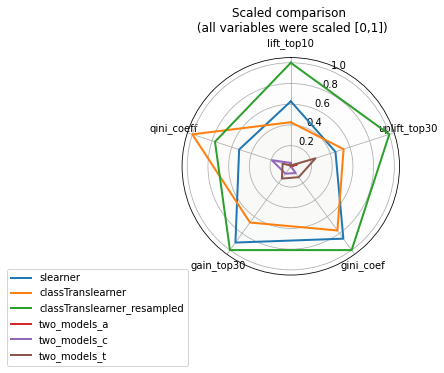

In [27]:
r = pd.DataFrame(result)
# r_normalized = r.apply(lambda x: (x - r.mean(axis = 1))/(r.std(axis = 1)))
r_normalized = r.apply(lambda x: (x - r.min(axis = 1))/(r.max(axis = 1)  - r.min(axis = 1)))
#Por normalizar se puede perder un modelo (el que tenga las variables con valores mas bajos)
categories = r_normalized.index
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for model in r_normalized .columns:
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    values=r_normalized[model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{model}")
    ax.fill(angles, values, alpha=0.010)
    ax.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))
    plt.title('Scaled comparison \n (all variables were scaled [0,1])')

In [28]:
r

,slearner,classTranslearner,classTranslearner_resampled,two_models_a,two_models_c,two_models_t
lift_top10,3.594518,3.467674,3.828521,3.199988,3.220501,3.205449
uplift_top30,0.035959,0.037419,0.045617,0.029014,0.027941,0.032374
gini_coef,0.467000,0.439000,0.506000,0.220000,0.243000,0.257000
gain_top30,67.090000,63.660000,68.380000,54.040000,55.300000,56.140000
qini_coeff,0.415000,0.696000,0.560000,0.105000,0.219000,0.154000


### Validacion

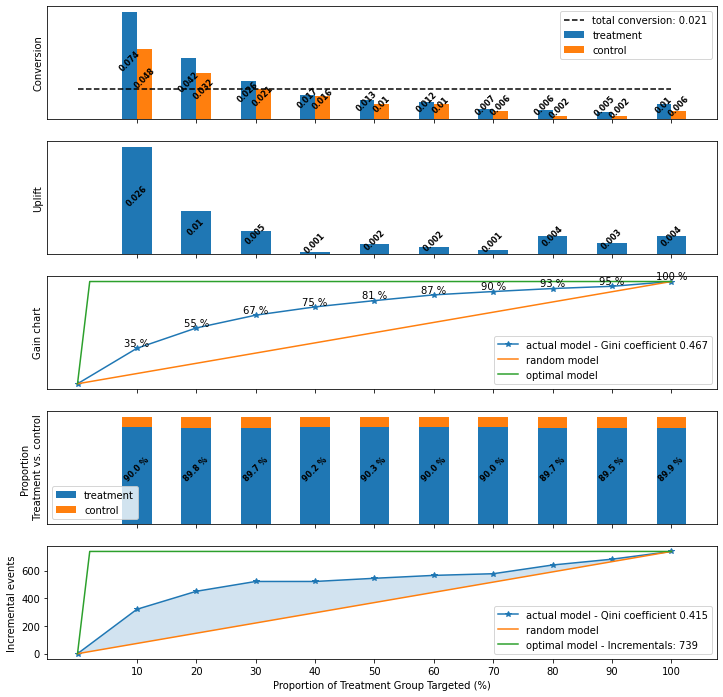

In [29]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           uplift_slearner,
                                                           plot = True)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0059'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

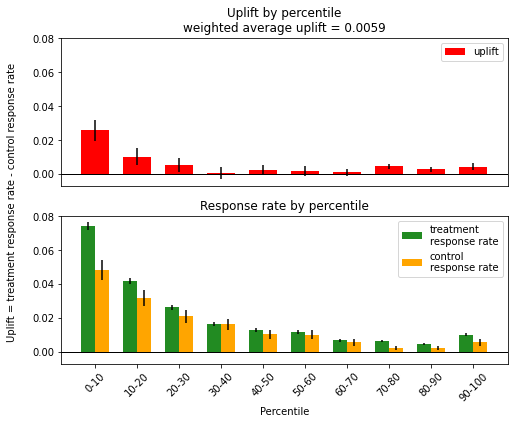

In [30]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_slearner,
                          treatment=test_treatment, kind='bar')

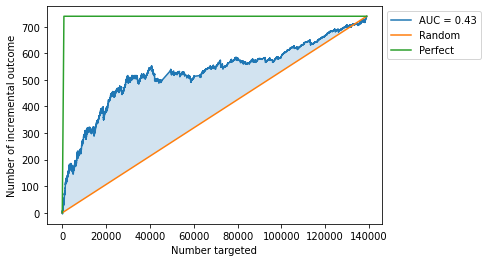

In [31]:
quin = plot_qini_curve(y_test,uplift_slearner,test_treatment,perfect=True,negative_effect = False)

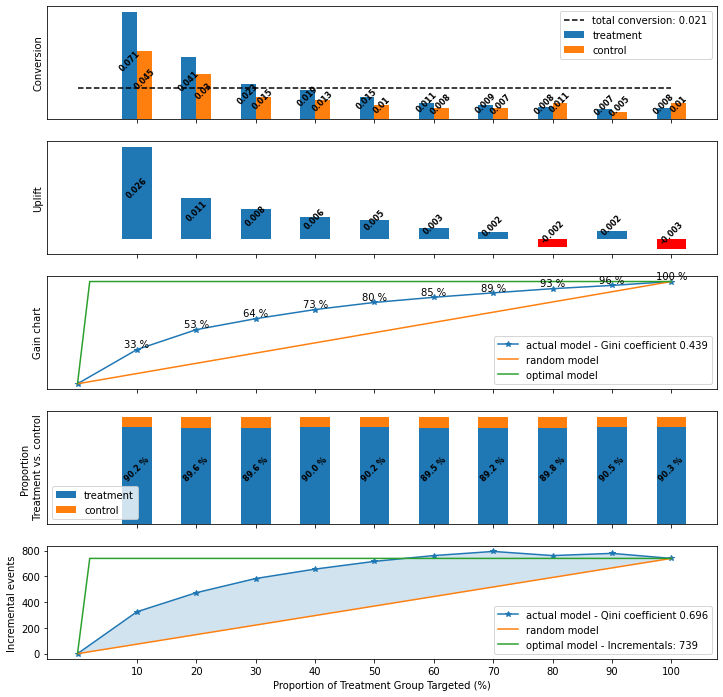

In [32]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                          test_treatment,
                                                          uplift_classTslearner,
                                                          plot = True)

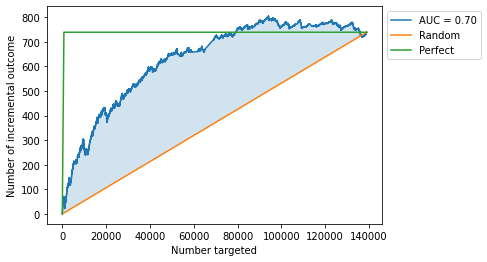

In [33]:
quin = plot_qini_curve(y_test,uplift_classTslearner,test_treatment,perfect=True,negative_effect = False)

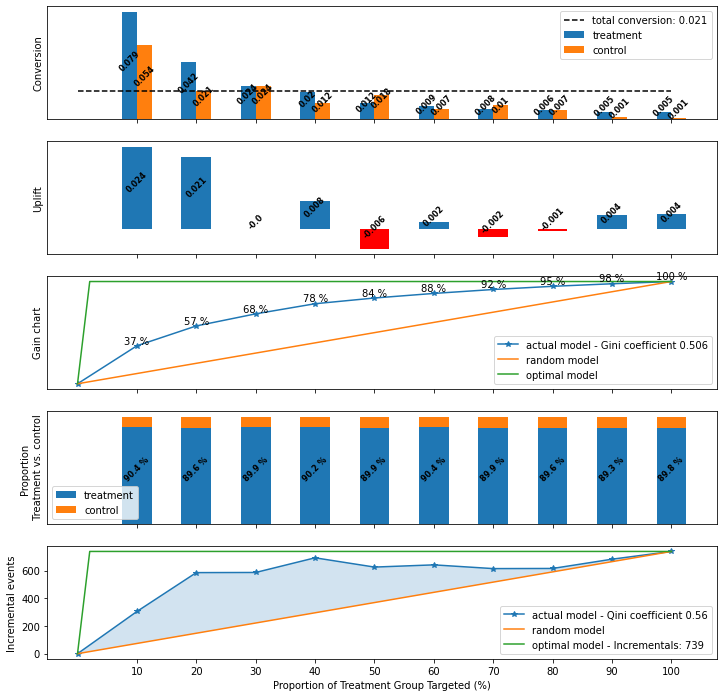

In [34]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                          test_treatment,
                                                          uplift_classTslearner_resampled,
                                                          plot = True)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0059'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

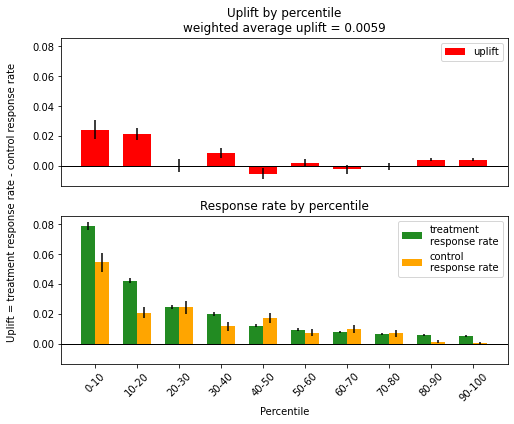

In [35]:
plot_uplift_by_percentile(y_true=y_test, uplift=uplift_classTslearner_resampled,
                          treatment=test_treatment, kind='bar')

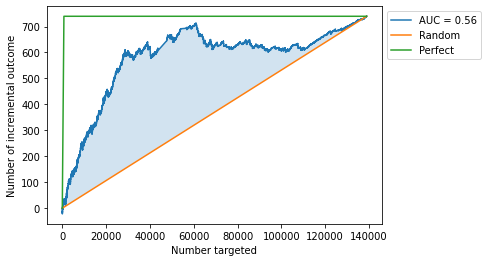

In [36]:
quin = plot_qini_curve(y_test,uplift_classTslearner_resampled,test_treatment,perfect=True,negative_effect = False)

In [37]:
qini_auc_score(y_true = y_test, 
                             uplift = uplift_classTslearner_resampled,
                             treatment = test_treatment,
                        )

0.0917878125744198